<a href="https://colab.research.google.com/github/CaioPassos3/AprendizagemDeMaquina/blob/main/Lista6AprendizagemDeMaquina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import KMeans
from numpy.linalg import inv, svd
from google.colab import files
import random

In [3]:
df = pd.read_csv('quake.csv')

print(df.head())

   -5.225999999999999801e+01  2.830000000000000071e+01
0                      45.53                    150.93
1                      41.85                    142.78
2                      29.19                    141.15
3                     -21.66                    169.81
4                      23.09                    120.58


Questão 1.

Considere o conjunto de dados disponível em quake.csv, organizado em 2 colunas
de atributos. Os dados referem-se a latitudes e longitudes de locais em
que foram registrados terremotos. Maiores detalhes sobre os dados podem ser
conferidos em https://www.openml.org/d/772.

In [4]:
# Normalizando os dados
scaler = StandardScaler()
X = scaler.fit_transform(df.values)

print("Dados normalizados:")
print(X[:5])

Dados normalizados:
[[ 1.23009322  0.80760106]
 [ 1.10950978  0.7390412 ]
 [ 0.69467656  0.72532923]
 [-0.97153744  0.96642441]
 [ 0.49479642  0.55228917]]


a) Avalie o algoritmo K-médias com distância Euclidiana na tarefa de agrupamento
para tais dados. O número de grupos deve ser escolhido entre os
valores 4, 5, 6, . . . , 19, 20 a partir do índice DB (Davies-Bouldin). Plote o
melhor resultado de agrupamento obtido.
Observação: Em cada avaliação repita múltiplas vezes (por exemplo, 20)
a execução do algoritmo K-médias, escolhendo a solução com melhor erro
de reconstrução.

In [5]:
def melhor_kmeans(X, n_clusters, n_repeats=20):
    melhor_modelo = None
    melhor_inertia = np.inf

    for _ in range(n_repeats):
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='random', random_state=random.randint(0, 10000))
        kmeans.fit(X)
        if kmeans.inertia_ < melhor_inertia:
            melhor_inertia = kmeans.inertia_
            melhor_modelo = kmeans
    return melhor_modelo

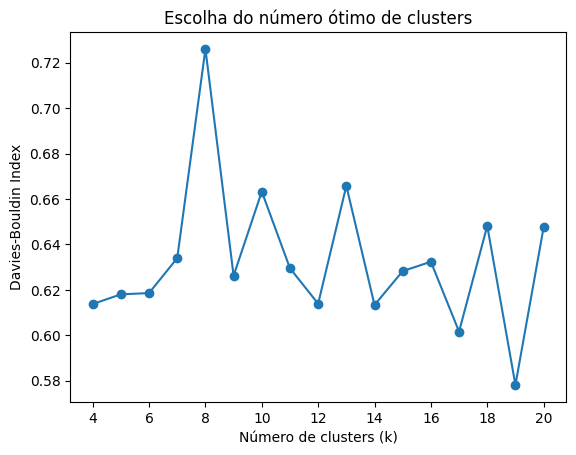

Melhor número de clusters: 19 com DB index = 0.5782


In [6]:
db_scores = []
ks = list(range(4, 21))
melhores_modelos = {}

for k in ks:
    modelo = melhor_kmeans(X, n_clusters=k, n_repeats=20)
    db_index = davies_bouldin_score(X, modelo.labels_)
    db_scores.append(db_index)
    melhores_modelos[k] = modelo

# Plotando o Davies-Bouldin para cada k
plt.plot(ks, db_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Davies-Bouldin Index')
plt.title('Escolha do número ótimo de clusters')
plt.show()

# Melhor k
k_melhor = ks[np.argmin(db_scores)]
print(f"Melhor número de clusters: {k_melhor} com DB index = {min(db_scores):.4f}")

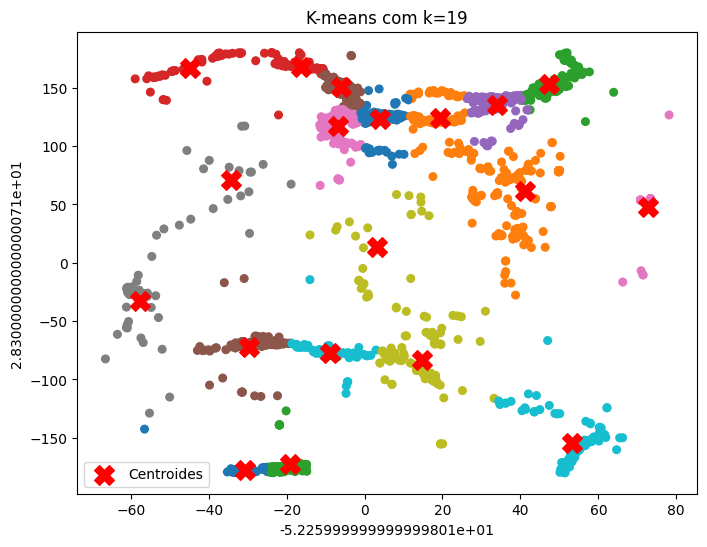

In [7]:
# Pegando o melhor modelo
modelo_final = melhores_modelos[k_melhor]

# Revertendo a normalização para visualizar nas coordenadas originais
centroids_original = scaler.inverse_transform(modelo_final.cluster_centers_)
labels = modelo_final.labels_

# Plotagem
plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=labels, cmap='tab10', s=30)
plt.scatter(centroids_original[:,0], centroids_original[:,1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f'K-means com k={k_melhor}')
plt.legend()
plt.show()

b) Repita o item anterior considerando a distância de Mahalanobis.
Observação: Note que o índice DB deve ser alterado para usar a distância
de Mahalanobis neste item.

In [9]:
# Função PCA com SVD
def pca_svd(X, n_components=None):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean
    U, S, VT = svd(X_centered, full_matrices=False)
    if n_components:
        return X_centered @ VT.T[:, :n_components], VT.T[:, :n_components]
    else:
        return X_centered @ VT.T, VT.T

In [10]:
# Calculando a matriz de covariância para Mahalanobis
cov = np.cov(X, rowvar=False)
inv_cov = inv(cov)

In [11]:
# Função para calcular distância de Mahalanobis
def mahalanobis(u, v, inv_cov):
    delta = u - v
    return np.sqrt(delta.T @ inv_cov @ delta)

In [12]:
# Implementação modificada do índice Davies-Bouldin com Mahalanobis
def davies_bouldin_mahalanobis(X, labels, cluster_centers, inv_cov):
    n_clusters = len(cluster_centers)
    S = np.zeros(n_clusters)
    for i in range(n_clusters):
        cluster_i = X[labels == i]
        S[i] = np.mean([mahalanobis(x, cluster_centers[i], inv_cov) for x in cluster_i])

    DB = 0
    for i in range(n_clusters):
        max_rij = 0
        for j in range(n_clusters):
            if i != j:
                Mij = mahalanobis(cluster_centers[i], cluster_centers[j], inv_cov)
                rij = (S[i] + S[j]) / Mij
                if rij > max_rij:
                    max_rij = rij
        DB += max_rij
    return DB / n_clusters

In [13]:
# Função para rodar o K-means várias vezes
def melhor_kmeans(X, n_clusters, n_repeats=20):
    melhor_modelo = None
    melhor_inertia = np.inf

    for _ in range(n_repeats):
        kmeans = KMeans(n_clusters=n_clusters, n_init=1, init='random', random_state=random.randint(0, 10000))
        kmeans.fit(X)
        if kmeans.inertia_ < melhor_inertia:
            melhor_inertia = kmeans.inertia_
            melhor_modelo = kmeans
    return melhor_modelo

In [14]:
# Testando vários valores de K
db_scores = []
ks = list(range(4, 21))
melhores_modelos = {}

for k in ks:
    modelo = melhor_kmeans(X, n_clusters=k, n_repeats=20)
    db_index = davies_bouldin_mahalanobis(X, modelo.labels_, modelo.cluster_centers_, inv_cov)
    db_scores.append(db_index)
    melhores_modelos[k] = modelo

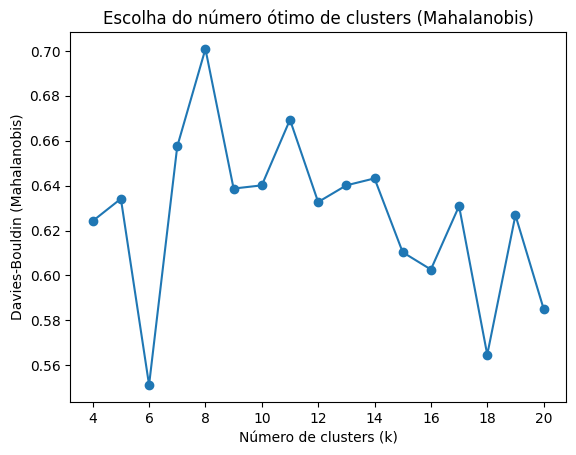

In [15]:
# Plotando o Davies-Bouldin Mahalanobis
plt.plot(ks, db_scores, marker='o')
plt.xlabel('Número de clusters (k)')
plt.ylabel('Davies-Bouldin (Mahalanobis)')
plt.title('Escolha do número ótimo de clusters (Mahalanobis)')
plt.show()

In [16]:
# Melhor k
k_melhor = ks[np.argmin(db_scores)]
print(f"Melhor número de clusters: {k_melhor} com DB index = {min(db_scores):.4f}")

Melhor número de clusters: 6 com DB index = 0.5512


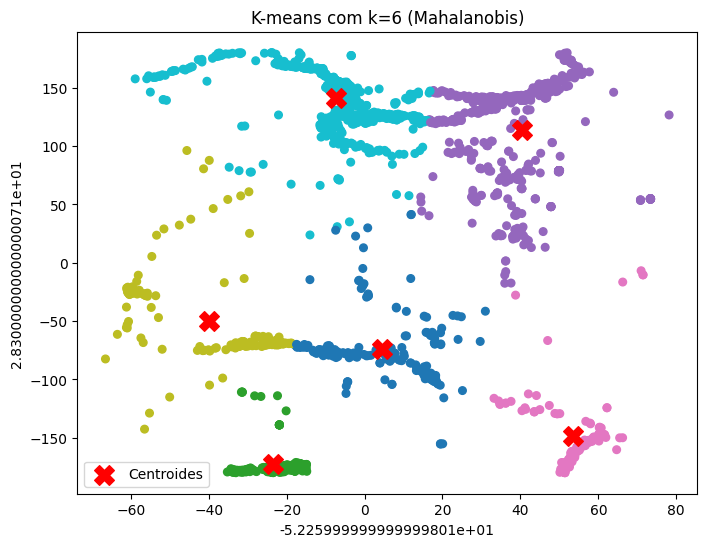

In [17]:
# Visualização final do melhor agrupamento
modelo_final = melhores_modelos[k_melhor]
centroids_original = scaler.inverse_transform(modelo_final.cluster_centers_)
labels = modelo_final.labels_

plt.figure(figsize=(8, 6))
plt.scatter(df.iloc[:,0], df.iloc[:,1], c=labels, cmap='tab10', s=30)
plt.scatter(centroids_original[:,0], centroids_original[:,1], c='red', marker='X', s=200, label='Centroides')
plt.xlabel(df.columns[0])
plt.ylabel(df.columns[1])
plt.title(f'K-means com k={k_melhor} (Mahalanobis)')
plt.legend()
plt.show()

Questão 2.

Considere o conjunto de dados disponível em penguins.csv, organizado em 5
colunas, sendo 4 colunas de atributos e a última a classe do padrão. Os dados
referem-se a medições anatômicas de pinguins da Antártida, classificados nas
espécies Adelie, Chinstrap e Gentoo. Maiores detalhes sobre os dados podem
ser conferidos em https://allisonhorst.github.io/palmerpenguins/.

In [18]:
df_penguins = pd.read_csv('penguins.csv')

df_penguins.head()

,3.910000000000000142e+01,1.869999999999999929e+01,1.810000000000000000e+02,3.750000000000000000e+03,0.000000000000000000e+00
0,39.5,17.4,186.0,3800.0,0.0
1,40.3,18.0,195.0,3250.0,0.0
2,36.7,19.3,193.0,3450.0,0.0
3,39.3,20.6,190.0,3650.0,0.0
4,38.9,17.8,181.0,3625.0,0.0


In [19]:
# Seleciona apenas os atributos numéricos
X = df_penguins.iloc[:, 0:4].values

# Normalização (padronização z-score)
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

a) Apresente a projeção em 2 dimensões dos padrões acima obtida pelo método
PCA (análise dos componentes principais).

In [20]:
# Calcula a matriz de covariância
cov_mat = np.cov(X_normalizado.T)

# Aplica SVD
U, S, Vt = np.linalg.svd(cov_mat)

# Seleciona os 2 primeiros componentes principais
W = U[:, :2]

# Projeta os dados nos dois componentes
X_pca = X_normalizado.dot(W)

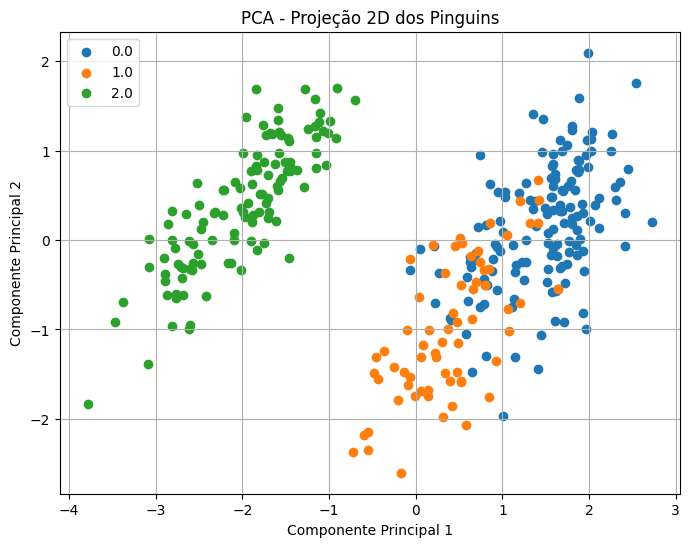

In [21]:
# Obtém as classes (última coluna do dataset)
y = df_penguins.iloc[:, 4].values

# Gráfico de dispersão
plt.figure(figsize=(8,6))

for especie in np.unique(y):
    idx = np.where(y == especie)
    plt.scatter(X_pca[idx, 0], X_pca[idx, 1], label=especie)

plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.title('PCA - Projeção 2D dos Pinguins')
plt.legend()
plt.grid()
plt.show()

b) Ainda considerando o item anterior, calcule e mostre a variância explicada
obtida quando a dimensão projetada é modificada (1,2,3 ou 4).

In [22]:
# Calcula a matriz de covariância
cov_mat = np.cov(X_normalizado.T)

# Aplica SVD
U, S, Vt = np.linalg.svd(cov_mat)

# As variâncias explicadas são os autovalores normalizados
variancias_explicadas = S / np.sum(S)

# Mostra a variância explicada acumulada para 1, 2, 3 e 4 componentes
for k in range(1, 5):
    var_acumulada = np.sum(variancias_explicadas[:k])
    print(f"Variância explicada com {k} componente(s): {var_acumulada*100:.2f}%")

Variância explicada com 1 componente(s): 68.59%
Variância explicada com 2 componente(s): 88.08%
Variância explicada com 3 componente(s): 97.31%
Variância explicada com 4 componente(s): 100.00%


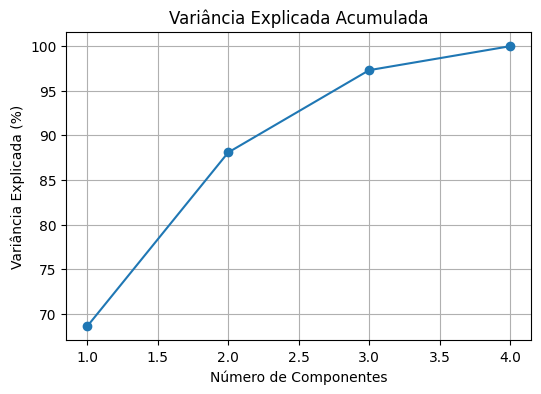

In [23]:
plt.figure(figsize=(6,4))
plt.plot(range(1, 5), np.cumsum(variancias_explicadas)*100, marker='o')
plt.title('Variância Explicada Acumulada')
plt.xlabel('Número de Componentes')
plt.ylabel('Variância Explicada (%)')
plt.grid()
plt.show()